# GAN FROM SCRATCH WITH PYTORCH
### A Basic GAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def make_generator_network(input_size=20, num_hidden_layers=1,num_hidden_units=100,num_output_units=784):
  model = nn.Sequential()

  for i in range(num_hidden_layers):
    model.add_module(f"fc_g{i}",nn.Linear(input_size,num_hidden_units))
    model.add_module(f"relu_g{i}",nn.LeakyReLU())
    input_size = num_hidden_units

  model.add_module(f"fc_g{num_hidden_layers}",nn.Linear(input_size,num_output_units))
  model.add_module(f"tanh_g",nn.Tanh())

  return model

In [ ]:
def make_discriminator_network(input_size,num_hidden_layers=1,num_hidden_units=100,num_output_units=1):
  model = nn.Sequential()

  for i in range(num_hidden_layers):
      model.add_module(f'fc_d{i}', nn.Linear(input_size,num_hidden_units, bias=False))
      model.add_module(f'relu_d{i}',nn.LeakyReLU())
      model.add_module('dropout', nn.Dropout(p=0.5))

      input_size = num_hidden_units

  model.add_module(f'fc_d{num_hidden_layers}',nn.Linear(input_size, num_output_units))
  model.add_module('sigmoid', nn.Sigmoid())
  return model

In [ ]:
import torch

image_size = (28,28)
z_size=20
gen_hidden_layers=1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

torch.manual_seed(1)

gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [ ]:
disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)

print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
import torchvision
from torchvision import transforms


image_path = './'
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5), std=(0.5))])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

example, label = next(iter(mnist_dataset))
print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)


 Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [ ]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

In [ ]:
from torch.utils.data import DataLoader


batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
input_real = input_real.view(batch_size, -1)

torch.manual_seed(1)
mode_z = 'uniform'  # 'uniform' vs. 'normal'
input_z = create_noise(batch_size, z_size, mode_z)

print('input-z -- shape:', input_z.shape)
print('input-real -- shape:', input_real.shape)

g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

input-z -- shape: torch.Size([32, 20])
input-real -- shape: torch.Size([32, 784])
Output of G -- shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


In [ ]:
loss_fn = nn.BCELoss()

## Loss for the Generator

g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')

## Loss for the Discriminator
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)

d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Discriminator Losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}')

Generator Loss: 0.6944
Discriminator Losses: Real 0.7758 Fake 0.6924


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 512

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)

## Set up the models
gen_model = make_generator_network(
    input_size=z_size,
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)).to(device)

disc_model = make_discriminator_network(
    input_size=np.prod(image_size),
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size).to(device)

## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [ ]:
def d_train(x):
  disc_model.zero_grad()

  batch_size = x.size(0)

  x = x.view(batch_size, -1).to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device)

  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

  # Train discriminator on a fake batch
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)

  d_proba_fake = disc_model(g_output)
  d_labels_fake = torch.zeros(batch_size, 1, device=device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

  # gradient backprop & optimize ONLY D's parameters
  d_loss = d_loss_real + d_loss_fake
  d_loss.backward()
  d_optimizer.step()

  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()



In [ ]:
## Train the generator
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [ ]:
from tqdm import tqdm

fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 100
torch.manual_seed(1)
for epoch in range(1, num_epochs+1):
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(tqdm(mnist_dl, desc=f"Epoch {epoch}/{num_epochs}")):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
          f' [D-Real: {all_d_real[-1]:.4f} D-Fake: {all_d_fake[-1]:.4f}]')
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 1/100: 100%|██████████| 117/117 [00:11<00:00, 10.25it/s]


Epoch 001 | Avg Losses >> G/D 1.3018/0.7790 [D-Real: 0.9029 D-Fake: 0.4378]


Epoch 2/100: 100%|██████████| 117/117 [00:11<00:00, 10.23it/s]


Epoch 002 | Avg Losses >> G/D 1.6738/0.3567 [D-Real: 0.9533 D-Fake: 0.2518]


Epoch 3/100: 100%|██████████| 117/117 [00:11<00:00, 10.35it/s]


Epoch 003 | Avg Losses >> G/D 0.7464/0.7601 [D-Real: 0.9227 D-Fake: 0.4869]


Epoch 4/100: 100%|██████████| 117/117 [00:11<00:00, 10.41it/s]


Epoch 004 | Avg Losses >> G/D 0.7521/0.7744 [D-Real: 0.9010 D-Fake: 0.4823]


Epoch 5/100: 100%|██████████| 117/117 [00:11<00:00, 10.38it/s]


Epoch 005 | Avg Losses >> G/D 0.6790/0.9024 [D-Real: 0.8415 D-Fake: 0.5129]


Epoch 6/100: 100%|██████████| 117/117 [00:11<00:00, 10.35it/s]


Epoch 006 | Avg Losses >> G/D 0.6506/1.0214 [D-Real: 0.7671 D-Fake: 0.5256]


Epoch 7/100: 100%|██████████| 117/117 [00:11<00:00, 10.16it/s]


Epoch 007 | Avg Losses >> G/D 0.8046/1.0034 [D-Real: 0.7200 D-Fake: 0.4714]


Epoch 8/100: 100%|██████████| 117/117 [00:11<00:00, 10.32it/s]


Epoch 008 | Avg Losses >> G/D 0.8982/0.9786 [D-Real: 0.7065 D-Fake: 0.4358]


Epoch 9/100: 100%|██████████| 117/117 [00:11<00:00, 10.32it/s]


Epoch 009 | Avg Losses >> G/D 1.0248/0.9954 [D-Real: 0.6751 D-Fake: 0.4024]


Epoch 10/100: 100%|██████████| 117/117 [00:11<00:00, 10.31it/s]


Epoch 010 | Avg Losses >> G/D 0.8509/1.1444 [D-Real: 0.6258 D-Fake: 0.4565]


Epoch 11/100: 100%|██████████| 117/117 [00:11<00:00, 10.27it/s]


Epoch 011 | Avg Losses >> G/D 0.9071/1.1659 [D-Real: 0.6026 D-Fake: 0.4499]


Epoch 12/100: 100%|██████████| 117/117 [00:11<00:00, 10.24it/s]


Epoch 012 | Avg Losses >> G/D 0.9318/1.1464 [D-Real: 0.6057 D-Fake: 0.4330]


Epoch 13/100: 100%|██████████| 117/117 [00:11<00:00, 10.12it/s]


Epoch 013 | Avg Losses >> G/D 1.0555/1.1612 [D-Real: 0.5854 D-Fake: 0.4196]


Epoch 14/100: 100%|██████████| 117/117 [00:11<00:00, 10.21it/s]


Epoch 014 | Avg Losses >> G/D 1.0030/1.0956 [D-Real: 0.6452 D-Fake: 0.4271]


Epoch 15/100: 100%|██████████| 117/117 [00:11<00:00, 10.22it/s]


Epoch 015 | Avg Losses >> G/D 1.0026/1.0419 [D-Real: 0.6545 D-Fake: 0.3988]


Epoch 16/100: 100%|██████████| 117/117 [00:11<00:00, 10.06it/s]


Epoch 016 | Avg Losses >> G/D 1.4444/0.9277 [D-Real: 0.6724 D-Fake: 0.3147]


Epoch 17/100: 100%|██████████| 117/117 [00:11<00:00, 10.29it/s]


Epoch 017 | Avg Losses >> G/D 1.2932/1.0721 [D-Real: 0.6205 D-Fake: 0.3633]


Epoch 18/100: 100%|██████████| 117/117 [00:11<00:00, 10.28it/s]


Epoch 018 | Avg Losses >> G/D 1.0180/1.0996 [D-Real: 0.6312 D-Fake: 0.4084]


Epoch 19/100: 100%|██████████| 117/117 [00:11<00:00, 10.32it/s]


Epoch 019 | Avg Losses >> G/D 0.9603/1.1848 [D-Real: 0.5750 D-Fake: 0.4110]


Epoch 20/100: 100%|██████████| 117/117 [00:11<00:00, 10.29it/s]


Epoch 020 | Avg Losses >> G/D 0.9564/1.1461 [D-Real: 0.6104 D-Fake: 0.4252]


Epoch 21/100: 100%|██████████| 117/117 [00:11<00:00, 10.18it/s]


Epoch 021 | Avg Losses >> G/D 0.9810/1.1807 [D-Real: 0.5835 D-Fake: 0.4078]


Epoch 22/100: 100%|██████████| 117/117 [00:11<00:00, 10.23it/s]


Epoch 022 | Avg Losses >> G/D 1.0001/1.0866 [D-Real: 0.6368 D-Fake: 0.4131]


Epoch 23/100: 100%|██████████| 117/117 [00:11<00:00, 10.33it/s]


Epoch 023 | Avg Losses >> G/D 1.0324/1.1517 [D-Real: 0.5949 D-Fake: 0.3901]


Epoch 24/100: 100%|██████████| 117/117 [00:11<00:00, 10.07it/s]


Epoch 024 | Avg Losses >> G/D 1.1316/1.1124 [D-Real: 0.6257 D-Fake: 0.3863]


Epoch 25/100: 100%|██████████| 117/117 [00:11<00:00, 10.22it/s]


Epoch 025 | Avg Losses >> G/D 1.0208/1.1974 [D-Real: 0.5736 D-Fake: 0.4023]


Epoch 26/100: 100%|██████████| 117/117 [00:11<00:00, 10.34it/s]


Epoch 026 | Avg Losses >> G/D 0.9338/1.1618 [D-Real: 0.5911 D-Fake: 0.4207]


Epoch 27/100: 100%|██████████| 117/117 [00:11<00:00, 10.33it/s]


Epoch 027 | Avg Losses >> G/D 1.0218/1.1526 [D-Real: 0.6039 D-Fake: 0.4058]


Epoch 28/100: 100%|██████████| 117/117 [00:11<00:00, 10.28it/s]


Epoch 028 | Avg Losses >> G/D 1.2253/1.1415 [D-Real: 0.6117 D-Fake: 0.3687]


Epoch 29/100: 100%|██████████| 117/117 [00:11<00:00, 10.25it/s]


Epoch 029 | Avg Losses >> G/D 1.2385/1.0312 [D-Real: 0.6553 D-Fake: 0.3734]


Epoch 30/100: 100%|██████████| 117/117 [00:11<00:00, 10.35it/s]


Epoch 030 | Avg Losses >> G/D 1.5252/1.0086 [D-Real: 0.6501 D-Fake: 0.3182]


Epoch 31/100: 100%|██████████| 117/117 [00:11<00:00, 10.21it/s]


Epoch 031 | Avg Losses >> G/D 1.0103/1.2305 [D-Real: 0.5685 D-Fake: 0.4294]


Epoch 32/100: 100%|██████████| 117/117 [00:11<00:00, 10.20it/s]


Epoch 032 | Avg Losses >> G/D 0.8764/1.2679 [D-Real: 0.5681 D-Fake: 0.4542]


Epoch 33/100: 100%|██████████| 117/117 [00:11<00:00,  9.98it/s]


Epoch 033 | Avg Losses >> G/D 0.9003/1.2259 [D-Real: 0.5681 D-Fake: 0.4312]


Epoch 34/100: 100%|██████████| 117/117 [00:11<00:00, 10.21it/s]


Epoch 034 | Avg Losses >> G/D 1.0486/1.1227 [D-Real: 0.6210 D-Fake: 0.4011]


Epoch 35/100: 100%|██████████| 117/117 [00:11<00:00, 10.26it/s]


Epoch 035 | Avg Losses >> G/D 1.1284/1.1007 [D-Real: 0.6220 D-Fake: 0.3758]


Epoch 36/100: 100%|██████████| 117/117 [00:11<00:00, 10.30it/s]


Epoch 036 | Avg Losses >> G/D 1.0387/1.2112 [D-Real: 0.5725 D-Fake: 0.4076]


Epoch 37/100: 100%|██████████| 117/117 [00:11<00:00, 10.29it/s]


Epoch 037 | Avg Losses >> G/D 0.9239/1.1972 [D-Real: 0.5798 D-Fake: 0.4192]


Epoch 38/100: 100%|██████████| 117/117 [00:11<00:00, 10.25it/s]


Epoch 038 | Avg Losses >> G/D 0.8361/1.2852 [D-Real: 0.5464 D-Fake: 0.4523]


Epoch 39/100: 100%|██████████| 117/117 [00:11<00:00, 10.22it/s]


Epoch 039 | Avg Losses >> G/D 0.9683/1.1993 [D-Real: 0.5811 D-Fake: 0.4209]


Epoch 40/100: 100%|██████████| 117/117 [00:11<00:00, 10.22it/s]


Epoch 040 | Avg Losses >> G/D 0.9936/1.1296 [D-Real: 0.6058 D-Fake: 0.4026]


Epoch 41/100: 100%|██████████| 117/117 [00:11<00:00, 10.05it/s]


Epoch 041 | Avg Losses >> G/D 1.0239/1.1762 [D-Real: 0.5925 D-Fake: 0.4059]


Epoch 42/100: 100%|██████████| 117/117 [00:11<00:00, 10.25it/s]


Epoch 042 | Avg Losses >> G/D 1.1671/1.0208 [D-Real: 0.6513 D-Fake: 0.3636]


Epoch 43/100: 100%|██████████| 117/117 [00:11<00:00, 10.15it/s]


Epoch 043 | Avg Losses >> G/D 1.4019/1.1024 [D-Real: 0.6089 D-Fake: 0.3501]


Epoch 44/100: 100%|██████████| 117/117 [00:11<00:00, 10.11it/s]


Epoch 044 | Avg Losses >> G/D 1.1610/1.0498 [D-Real: 0.6413 D-Fake: 0.3693]


Epoch 45/100: 100%|██████████| 117/117 [00:11<00:00, 10.09it/s]


Epoch 045 | Avg Losses >> G/D 0.9735/1.1543 [D-Real: 0.6023 D-Fake: 0.4024]


Epoch 46/100: 100%|██████████| 117/117 [00:11<00:00, 10.10it/s]


Epoch 046 | Avg Losses >> G/D 1.0183/1.1389 [D-Real: 0.6008 D-Fake: 0.3952]


Epoch 47/100: 100%|██████████| 117/117 [00:11<00:00, 10.18it/s]


Epoch 047 | Avg Losses >> G/D 0.9446/1.1865 [D-Real: 0.5886 D-Fake: 0.4167]


Epoch 48/100: 100%|██████████| 117/117 [00:11<00:00, 10.10it/s]


Epoch 048 | Avg Losses >> G/D 1.0246/1.1308 [D-Real: 0.6112 D-Fake: 0.3998]


Epoch 49/100: 100%|██████████| 117/117 [00:11<00:00, 10.05it/s]


Epoch 049 | Avg Losses >> G/D 1.0356/1.1491 [D-Real: 0.5946 D-Fake: 0.3899]


Epoch 50/100: 100%|██████████| 117/117 [00:11<00:00, 10.16it/s]


Epoch 050 | Avg Losses >> G/D 1.0196/1.2652 [D-Real: 0.5418 D-Fake: 0.4170]


Epoch 51/100: 100%|██████████| 117/117 [00:11<00:00, 10.23it/s]


Epoch 051 | Avg Losses >> G/D 0.9540/1.1923 [D-Real: 0.5874 D-Fake: 0.4215]


Epoch 52/100: 100%|██████████| 117/117 [00:11<00:00, 10.06it/s]


Epoch 052 | Avg Losses >> G/D 0.9899/1.2096 [D-Real: 0.5825 D-Fake: 0.4250]


Epoch 53/100: 100%|██████████| 117/117 [00:11<00:00, 10.19it/s]


Epoch 053 | Avg Losses >> G/D 1.1705/1.1173 [D-Real: 0.6064 D-Fake: 0.3755]


Epoch 54/100: 100%|██████████| 117/117 [00:11<00:00, 10.21it/s]


Epoch 054 | Avg Losses >> G/D 1.1730/1.1198 [D-Real: 0.6110 D-Fake: 0.3846]


Epoch 55/100: 100%|██████████| 117/117 [00:11<00:00, 10.16it/s]


Epoch 055 | Avg Losses >> G/D 1.0929/1.1830 [D-Real: 0.5900 D-Fake: 0.4033]


Epoch 56/100: 100%|██████████| 117/117 [00:11<00:00, 10.17it/s]


Epoch 056 | Avg Losses >> G/D 1.2257/1.1214 [D-Real: 0.6227 D-Fake: 0.3805]


Epoch 57/100: 100%|██████████| 117/117 [00:11<00:00, 10.18it/s]


Epoch 057 | Avg Losses >> G/D 1.2424/1.0954 [D-Real: 0.6194 D-Fake: 0.3754]


Epoch 58/100: 100%|██████████| 117/117 [00:11<00:00,  9.97it/s]


Epoch 058 | Avg Losses >> G/D 1.1342/1.0995 [D-Real: 0.6130 D-Fake: 0.3716]


Epoch 59/100: 100%|██████████| 117/117 [00:11<00:00, 10.22it/s]


Epoch 059 | Avg Losses >> G/D 1.0143/1.1614 [D-Real: 0.6040 D-Fake: 0.4143]


Epoch 60/100: 100%|██████████| 117/117 [00:11<00:00, 10.22it/s]


Epoch 060 | Avg Losses >> G/D 1.0781/1.1389 [D-Real: 0.6073 D-Fake: 0.3915]


Epoch 61/100: 100%|██████████| 117/117 [00:11<00:00, 10.24it/s]


Epoch 061 | Avg Losses >> G/D 1.1817/1.1089 [D-Real: 0.6145 D-Fake: 0.3690]


Epoch 62/100: 100%|██████████| 117/117 [00:11<00:00, 10.31it/s]


Epoch 062 | Avg Losses >> G/D 1.2083/1.0572 [D-Real: 0.6489 D-Fake: 0.3692]


Epoch 63/100: 100%|██████████| 117/117 [00:11<00:00, 10.33it/s]


Epoch 063 | Avg Losses >> G/D 1.1669/1.0872 [D-Real: 0.6339 D-Fake: 0.3730]


Epoch 64/100: 100%|██████████| 117/117 [00:11<00:00, 10.38it/s]


Epoch 064 | Avg Losses >> G/D 1.0715/1.1436 [D-Real: 0.6116 D-Fake: 0.3993]


Epoch 65/100: 100%|██████████| 117/117 [00:11<00:00, 10.30it/s]


Epoch 065 | Avg Losses >> G/D 1.3215/1.0568 [D-Real: 0.6390 D-Fake: 0.3530]


Epoch 66/100: 100%|██████████| 117/117 [00:11<00:00, 10.01it/s]


Epoch 066 | Avg Losses >> G/D 1.2067/1.1102 [D-Real: 0.6224 D-Fake: 0.3826]


Epoch 67/100: 100%|██████████| 117/117 [00:11<00:00, 10.22it/s]


Epoch 067 | Avg Losses >> G/D 1.3429/1.0130 [D-Real: 0.6635 D-Fake: 0.3570]


Epoch 68/100: 100%|██████████| 117/117 [00:11<00:00, 10.28it/s]


Epoch 068 | Avg Losses >> G/D 1.2338/1.0645 [D-Real: 0.6398 D-Fake: 0.3676]


Epoch 69/100: 100%|██████████| 117/117 [00:11<00:00, 10.28it/s]


Epoch 069 | Avg Losses >> G/D 1.1335/1.0642 [D-Real: 0.6421 D-Fake: 0.3811]


Epoch 70/100: 100%|██████████| 117/117 [00:11<00:00, 10.27it/s]


Epoch 070 | Avg Losses >> G/D 1.2071/1.0448 [D-Real: 0.6414 D-Fake: 0.3615]


Epoch 71/100: 100%|██████████| 117/117 [00:11<00:00, 10.34it/s]


Epoch 071 | Avg Losses >> G/D 1.2596/1.0362 [D-Real: 0.6457 D-Fake: 0.3529]


Epoch 72/100: 100%|██████████| 117/117 [00:11<00:00, 10.24it/s]


Epoch 072 | Avg Losses >> G/D 1.2141/0.9933 [D-Real: 0.6713 D-Fake: 0.3544]


Epoch 73/100: 100%|██████████| 117/117 [00:11<00:00, 10.29it/s]


Epoch 073 | Avg Losses >> G/D 1.2815/1.0151 [D-Real: 0.6506 D-Fake: 0.3366]


Epoch 74/100: 100%|██████████| 117/117 [00:11<00:00, 10.04it/s]


Epoch 074 | Avg Losses >> G/D 1.3312/1.0042 [D-Real: 0.6617 D-Fake: 0.3403]


Epoch 75/100: 100%|██████████| 117/117 [00:11<00:00, 10.28it/s]


Epoch 075 | Avg Losses >> G/D 1.2240/1.0621 [D-Real: 0.6409 D-Fake: 0.3654]


Epoch 76/100: 100%|██████████| 117/117 [00:11<00:00, 10.27it/s]


Epoch 076 | Avg Losses >> G/D 1.1255/1.0492 [D-Real: 0.6519 D-Fake: 0.3760]


Epoch 77/100: 100%|██████████| 117/117 [00:11<00:00, 10.29it/s]


Epoch 077 | Avg Losses >> G/D 1.2442/1.0947 [D-Real: 0.6304 D-Fake: 0.3610]


Epoch 78/100: 100%|██████████| 117/117 [00:11<00:00, 10.31it/s]


Epoch 078 | Avg Losses >> G/D 1.5062/0.9469 [D-Real: 0.6855 D-Fake: 0.3216]


Epoch 79/100: 100%|██████████| 117/117 [00:11<00:00, 10.28it/s]


Epoch 079 | Avg Losses >> G/D 1.3403/1.0099 [D-Real: 0.6666 D-Fake: 0.3442]


Epoch 80/100: 100%|██████████| 117/117 [00:11<00:00, 10.28it/s]


Epoch 080 | Avg Losses >> G/D 1.2142/1.0663 [D-Real: 0.6470 D-Fake: 0.3635]


Epoch 81/100: 100%|██████████| 117/117 [00:11<00:00, 10.31it/s]


Epoch 081 | Avg Losses >> G/D 1.2295/1.0594 [D-Real: 0.6466 D-Fake: 0.3692]


Epoch 82/100: 100%|██████████| 117/117 [00:11<00:00, 10.30it/s]


Epoch 082 | Avg Losses >> G/D 1.1990/1.0707 [D-Real: 0.6430 D-Fake: 0.3658]


Epoch 83/100: 100%|██████████| 117/117 [00:11<00:00, 10.02it/s]


Epoch 083 | Avg Losses >> G/D 1.3266/1.0153 [D-Real: 0.6566 D-Fake: 0.3470]


Epoch 84/100: 100%|██████████| 117/117 [00:11<00:00, 10.33it/s]


Epoch 084 | Avg Losses >> G/D 1.2337/1.0222 [D-Real: 0.6594 D-Fake: 0.3602]


Epoch 85/100: 100%|██████████| 117/117 [00:11<00:00, 10.21it/s]


Epoch 085 | Avg Losses >> G/D 1.1920/1.0789 [D-Real: 0.6353 D-Fake: 0.3675]


Epoch 86/100: 100%|██████████| 117/117 [00:11<00:00, 10.28it/s]


Epoch 086 | Avg Losses >> G/D 1.1708/1.0647 [D-Real: 0.6460 D-Fake: 0.3693]


Epoch 87/100: 100%|██████████| 117/117 [00:11<00:00, 10.23it/s]


Epoch 087 | Avg Losses >> G/D 1.2337/1.0756 [D-Real: 0.6335 D-Fake: 0.3576]


Epoch 88/100: 100%|██████████| 117/117 [00:11<00:00, 10.22it/s]


Epoch 088 | Avg Losses >> G/D 1.2087/1.0543 [D-Real: 0.6515 D-Fake: 0.3675]


Epoch 89/100: 100%|██████████| 117/117 [00:11<00:00, 10.26it/s]


Epoch 089 | Avg Losses >> G/D 1.1623/1.0905 [D-Real: 0.6308 D-Fake: 0.3740]


Epoch 90/100: 100%|██████████| 117/117 [00:11<00:00, 10.23it/s]


Epoch 090 | Avg Losses >> G/D 1.1990/1.0531 [D-Real: 0.6480 D-Fake: 0.3633]


Epoch 91/100: 100%|██████████| 117/117 [00:11<00:00, 10.01it/s]


Epoch 091 | Avg Losses >> G/D 1.1356/1.1260 [D-Real: 0.6126 D-Fake: 0.3823]


Epoch 92/100: 100%|██████████| 117/117 [00:11<00:00, 10.27it/s]


Epoch 092 | Avg Losses >> G/D 1.2141/1.0267 [D-Real: 0.6582 D-Fake: 0.3588]


Epoch 93/100: 100%|██████████| 117/117 [00:11<00:00, 10.15it/s]


Epoch 093 | Avg Losses >> G/D 1.1239/1.1070 [D-Real: 0.6250 D-Fake: 0.3775]


Epoch 94/100: 100%|██████████| 117/117 [00:11<00:00, 10.21it/s]


Epoch 094 | Avg Losses >> G/D 1.1617/1.0722 [D-Real: 0.6380 D-Fake: 0.3658]


Epoch 95/100: 100%|██████████| 117/117 [00:11<00:00, 10.26it/s]


Epoch 095 | Avg Losses >> G/D 1.1375/1.0915 [D-Real: 0.6350 D-Fake: 0.3746]


Epoch 96/100: 100%|██████████| 117/117 [00:11<00:00, 10.11it/s]


Epoch 096 | Avg Losses >> G/D 1.1897/1.0731 [D-Real: 0.6373 D-Fake: 0.3663]


Epoch 97/100: 100%|██████████| 117/117 [00:11<00:00, 10.18it/s]


Epoch 097 | Avg Losses >> G/D 1.1543/1.0890 [D-Real: 0.6341 D-Fake: 0.3715]


Epoch 98/100: 100%|██████████| 117/117 [00:11<00:00, 10.21it/s]


Epoch 098 | Avg Losses >> G/D 1.1967/1.0658 [D-Real: 0.6402 D-Fake: 0.3657]


Epoch 99/100: 100%|██████████| 117/117 [00:11<00:00, 10.28it/s]


Epoch 099 | Avg Losses >> G/D 1.1613/1.0767 [D-Real: 0.6384 D-Fake: 0.3679]


Epoch 100/100: 100%|██████████| 117/117 [00:11<00:00, 10.08it/s]

Epoch 100 | Avg Losses >> G/D 1.1817/1.0975 [D-Real: 0.6237 D-Fake: 0.3690]


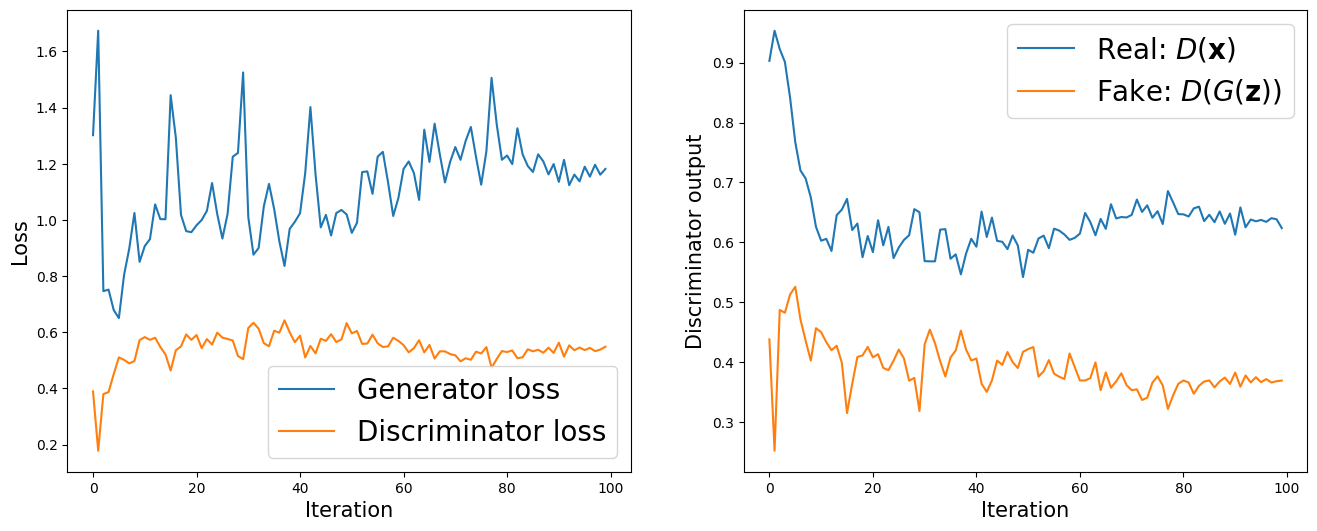

In [ ]:
import itertools


fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)

plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

#plt.savefig('figures/ch17-gan-learning-curve.pdf')
plt.show()

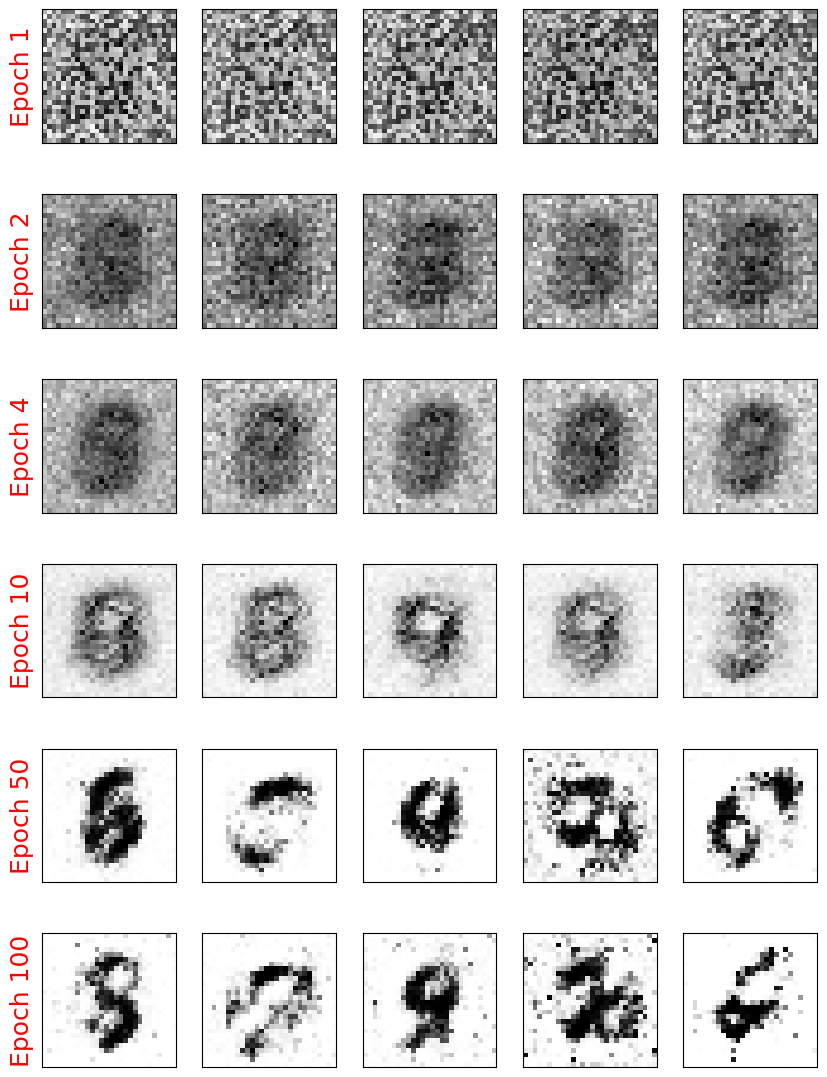

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

#plt.savefig('figures/ch17-vanila-gan-samples.pdf')
plt.show()

#Improving the quality of synthesized images using a convolutional and Wasserstein GAN

## DCGAN


In [ ]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

device

device(type='cuda', index=0)

In [ ]:
import torchvision
from torchvision import transforms


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

batch_size = 512

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.05MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]


In [ ]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(

        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())

    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [ ]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [ ]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [ ]:
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()
## Train the generator
def g_train(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [ ]:
from tqdm import tqdm

mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(tqdm(mnist_dl,desc=f"Epoch {epoch}/{num_epochs}")):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))

    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 1/100: 100%|██████████| 117/117 [00:12<00:00,  9.00it/s]


Epoch 001 | Avg Losses >> G/D 2.7946/0.3083


Epoch 2/100: 100%|██████████| 117/117 [00:12<00:00,  9.43it/s]


Epoch 002 | Avg Losses >> G/D 4.3167/0.1009


Epoch 3/100: 100%|██████████| 117/117 [00:12<00:00,  9.31it/s]


Epoch 003 | Avg Losses >> G/D 4.7706/0.0618


Epoch 4/100: 100%|██████████| 117/117 [00:12<00:00,  9.36it/s]


Epoch 004 | Avg Losses >> G/D 4.9270/0.0543


Epoch 5/100: 100%|██████████| 117/117 [00:12<00:00,  9.47it/s]


Epoch 005 | Avg Losses >> G/D 4.7778/0.0968


Epoch 6/100: 100%|██████████| 117/117 [00:12<00:00,  9.44it/s]


Epoch 006 | Avg Losses >> G/D 4.7179/0.1127


Epoch 7/100: 100%|██████████| 117/117 [00:12<00:00,  9.43it/s]


Epoch 007 | Avg Losses >> G/D 4.7234/0.0661


Epoch 8/100: 100%|██████████| 117/117 [00:12<00:00,  9.45it/s]


Epoch 008 | Avg Losses >> G/D 4.9777/0.0708


Epoch 9/100: 100%|██████████| 117/117 [00:12<00:00,  9.21it/s]


Epoch 009 | Avg Losses >> G/D 5.3224/0.0659


Epoch 10/100: 100%|██████████| 117/117 [00:12<00:00,  9.44it/s]


Epoch 010 | Avg Losses >> G/D 5.4478/0.0519


Epoch 11/100: 100%|██████████| 117/117 [00:12<00:00,  9.41it/s]


Epoch 011 | Avg Losses >> G/D 5.6312/0.0436


Epoch 12/100: 100%|██████████| 117/117 [00:12<00:00,  9.43it/s]


Epoch 012 | Avg Losses >> G/D 5.7143/0.0591


Epoch 13/100: 100%|██████████| 117/117 [00:12<00:00,  9.52it/s]


Epoch 013 | Avg Losses >> G/D 5.0837/0.1136


Epoch 14/100: 100%|██████████| 117/117 [00:12<00:00,  9.29it/s]


Epoch 014 | Avg Losses >> G/D 4.7191/0.0955


Epoch 15/100: 100%|██████████| 117/117 [00:12<00:00,  9.45it/s]


Epoch 015 | Avg Losses >> G/D 5.0002/0.1288


Epoch 16/100: 100%|██████████| 117/117 [00:12<00:00,  9.46it/s]


Epoch 016 | Avg Losses >> G/D 4.6167/0.1033


Epoch 17/100: 100%|██████████| 117/117 [00:12<00:00,  9.46it/s]


Epoch 017 | Avg Losses >> G/D 4.5393/0.1079


Epoch 18/100: 100%|██████████| 117/117 [00:12<00:00,  9.44it/s]


Epoch 018 | Avg Losses >> G/D 4.6372/0.1254


Epoch 19/100: 100%|██████████| 117/117 [00:12<00:00,  9.53it/s]


Epoch 019 | Avg Losses >> G/D 4.6411/0.1758


Epoch 20/100: 100%|██████████| 117/117 [00:12<00:00,  9.39it/s]


Epoch 020 | Avg Losses >> G/D 5.0497/0.0979


Epoch 21/100: 100%|██████████| 117/117 [00:12<00:00,  9.50it/s]


Epoch 021 | Avg Losses >> G/D 5.0691/0.0926


Epoch 22/100: 100%|██████████| 117/117 [00:12<00:00,  9.49it/s]


Epoch 022 | Avg Losses >> G/D 4.7669/0.1027


Epoch 23/100: 100%|██████████| 117/117 [00:12<00:00,  9.52it/s]


Epoch 023 | Avg Losses >> G/D 4.7855/0.1452


Epoch 24/100: 100%|██████████| 117/117 [00:12<00:00,  9.52it/s]


Epoch 024 | Avg Losses >> G/D 4.4448/0.1666


Epoch 25/100: 100%|██████████| 117/117 [00:12<00:00,  9.34it/s]


Epoch 025 | Avg Losses >> G/D 4.2445/0.1821


Epoch 26/100: 100%|██████████| 117/117 [00:12<00:00,  9.39it/s]


Epoch 026 | Avg Losses >> G/D 4.4608/0.1398


Epoch 27/100: 100%|██████████| 117/117 [00:12<00:00,  9.39it/s]


Epoch 027 | Avg Losses >> G/D 4.1703/0.1783


Epoch 28/100: 100%|██████████| 117/117 [00:12<00:00,  9.51it/s]


Epoch 028 | Avg Losses >> G/D 4.0334/0.2185


Epoch 29/100: 100%|██████████| 117/117 [00:12<00:00,  9.47it/s]


Epoch 029 | Avg Losses >> G/D 3.7736/0.2163


Epoch 30/100: 100%|██████████| 117/117 [00:12<00:00,  9.45it/s]


Epoch 030 | Avg Losses >> G/D 3.5168/0.2496


Epoch 31/100: 100%|██████████| 117/117 [00:12<00:00,  9.38it/s]


Epoch 031 | Avg Losses >> G/D 3.5724/0.1932


Epoch 32/100: 100%|██████████| 117/117 [00:12<00:00,  9.48it/s]


Epoch 032 | Avg Losses >> G/D 3.5425/0.2124


Epoch 33/100: 100%|██████████| 117/117 [00:12<00:00,  9.44it/s]


Epoch 033 | Avg Losses >> G/D 3.6558/0.2147


Epoch 34/100: 100%|██████████| 117/117 [00:12<00:00,  9.50it/s]


Epoch 034 | Avg Losses >> G/D 3.6748/0.2885


Epoch 35/100: 100%|██████████| 117/117 [00:12<00:00,  9.50it/s]


Epoch 035 | Avg Losses >> G/D 3.5590/0.1968


Epoch 36/100: 100%|██████████| 117/117 [00:12<00:00,  9.38it/s]


Epoch 036 | Avg Losses >> G/D 3.6029/0.2095


Epoch 37/100: 100%|██████████| 117/117 [00:12<00:00,  9.29it/s]


Epoch 037 | Avg Losses >> G/D 3.6743/0.2709


Epoch 38/100: 100%|██████████| 117/117 [00:12<00:00,  9.38it/s]


Epoch 038 | Avg Losses >> G/D 3.4406/0.3457


Epoch 39/100: 100%|██████████| 117/117 [00:12<00:00,  9.45it/s]


Epoch 039 | Avg Losses >> G/D 3.3452/0.2712


Epoch 40/100: 100%|██████████| 117/117 [00:12<00:00,  9.48it/s]


Epoch 040 | Avg Losses >> G/D 3.2842/0.2558


Epoch 41/100: 100%|██████████| 117/117 [00:12<00:00,  9.49it/s]


Epoch 041 | Avg Losses >> G/D 3.1821/0.2559


Epoch 42/100: 100%|██████████| 117/117 [00:12<00:00,  9.40it/s]


Epoch 042 | Avg Losses >> G/D 3.0831/0.2415


Epoch 43/100: 100%|██████████| 117/117 [00:12<00:00,  9.38it/s]


Epoch 043 | Avg Losses >> G/D 3.2100/0.2369


Epoch 44/100: 100%|██████████| 117/117 [00:12<00:00,  9.44it/s]


Epoch 044 | Avg Losses >> G/D 3.1896/0.2627


Epoch 45/100: 100%|██████████| 117/117 [00:12<00:00,  9.49it/s]


Epoch 045 | Avg Losses >> G/D 3.0702/0.2875


Epoch 46/100: 100%|██████████| 117/117 [00:12<00:00,  9.31it/s]


Epoch 046 | Avg Losses >> G/D 3.1501/0.3197


Epoch 47/100: 100%|██████████| 117/117 [00:12<00:00,  9.25it/s]


Epoch 047 | Avg Losses >> G/D 3.1251/0.2340


Epoch 48/100: 100%|██████████| 117/117 [00:12<00:00,  9.33it/s]


Epoch 048 | Avg Losses >> G/D 3.0681/0.2774


Epoch 49/100: 100%|██████████| 117/117 [00:12<00:00,  9.31it/s]


Epoch 049 | Avg Losses >> G/D 3.0887/0.2857


Epoch 50/100: 100%|██████████| 117/117 [00:12<00:00,  9.40it/s]


Epoch 050 | Avg Losses >> G/D 3.0814/0.3053


Epoch 51/100: 100%|██████████| 117/117 [00:12<00:00,  9.42it/s]


Epoch 051 | Avg Losses >> G/D 2.9730/0.2783


Epoch 52/100: 100%|██████████| 117/117 [00:12<00:00,  9.50it/s]


Epoch 052 | Avg Losses >> G/D 3.0059/0.3116


Epoch 53/100: 100%|██████████| 117/117 [00:12<00:00,  9.35it/s]


Epoch 053 | Avg Losses >> G/D 3.0055/0.2778


Epoch 54/100: 100%|██████████| 117/117 [00:12<00:00,  9.47it/s]


Epoch 054 | Avg Losses >> G/D 2.9750/0.3334


Epoch 55/100: 100%|██████████| 117/117 [00:12<00:00,  9.46it/s]


Epoch 055 | Avg Losses >> G/D 2.8979/0.3044


Epoch 56/100: 100%|██████████| 117/117 [00:12<00:00,  9.47it/s]


Epoch 056 | Avg Losses >> G/D 2.8615/0.3130


Epoch 57/100: 100%|██████████| 117/117 [00:12<00:00,  9.46it/s]


Epoch 057 | Avg Losses >> G/D 2.8899/0.3186


Epoch 58/100: 100%|██████████| 117/117 [00:12<00:00,  9.49it/s]


Epoch 058 | Avg Losses >> G/D 2.8671/0.3770


Epoch 59/100: 100%|██████████| 117/117 [00:12<00:00,  9.28it/s]


Epoch 059 | Avg Losses >> G/D 2.9049/0.3552


Epoch 60/100: 100%|██████████| 117/117 [00:12<00:00,  9.44it/s]


Epoch 060 | Avg Losses >> G/D 2.7935/0.3643


Epoch 61/100: 100%|██████████| 117/117 [00:12<00:00,  9.51it/s]


Epoch 061 | Avg Losses >> G/D 2.7605/0.3317


Epoch 62/100: 100%|██████████| 117/117 [00:12<00:00,  9.37it/s]


Epoch 062 | Avg Losses >> G/D 2.7675/0.3126


Epoch 63/100: 100%|██████████| 117/117 [00:12<00:00,  9.41it/s]


Epoch 063 | Avg Losses >> G/D 2.7092/0.3234


Epoch 64/100: 100%|██████████| 117/117 [00:12<00:00,  9.28it/s]


Epoch 064 | Avg Losses >> G/D 2.7164/0.3437


Epoch 65/100: 100%|██████████| 117/117 [00:12<00:00,  9.44it/s]


Epoch 065 | Avg Losses >> G/D 2.7718/0.3417


Epoch 66/100: 100%|██████████| 117/117 [00:12<00:00,  9.46it/s]


Epoch 066 | Avg Losses >> G/D 2.7957/0.3018


Epoch 67/100: 100%|██████████| 117/117 [00:12<00:00,  9.48it/s]


Epoch 067 | Avg Losses >> G/D 2.7544/0.3504


Epoch 68/100: 100%|██████████| 117/117 [00:12<00:00,  9.48it/s]


Epoch 068 | Avg Losses >> G/D 2.7499/0.3364


Epoch 69/100: 100%|██████████| 117/117 [00:12<00:00,  9.45it/s]


Epoch 069 | Avg Losses >> G/D 2.8135/0.3719


Epoch 70/100: 100%|██████████| 117/117 [00:12<00:00,  9.28it/s]


Epoch 070 | Avg Losses >> G/D 2.7080/0.3543


Epoch 71/100: 100%|██████████| 117/117 [00:12<00:00,  9.46it/s]


Epoch 071 | Avg Losses >> G/D 2.8081/0.3217


Epoch 72/100: 100%|██████████| 117/117 [00:12<00:00,  9.43it/s]


Epoch 072 | Avg Losses >> G/D 2.7707/0.3295


Epoch 73/100: 100%|██████████| 117/117 [00:12<00:00,  9.40it/s]


Epoch 073 | Avg Losses >> G/D 2.7502/0.3429


Epoch 74/100: 100%|██████████| 117/117 [00:12<00:00,  9.52it/s]


Epoch 074 | Avg Losses >> G/D 2.7091/0.3500


Epoch 75/100: 100%|██████████| 117/117 [00:12<00:00,  9.34it/s]


Epoch 075 | Avg Losses >> G/D 2.7781/0.3402


Epoch 76/100: 100%|██████████| 117/117 [00:12<00:00,  9.35it/s]


Epoch 076 | Avg Losses >> G/D 2.7071/0.3236


Epoch 77/100: 100%|██████████| 117/117 [00:12<00:00,  9.42it/s]


Epoch 077 | Avg Losses >> G/D 2.8023/0.3162


Epoch 78/100: 100%|██████████| 117/117 [00:12<00:00,  9.35it/s]


Epoch 078 | Avg Losses >> G/D 2.7521/0.3234


Epoch 79/100: 100%|██████████| 117/117 [00:12<00:00,  9.41it/s]


Epoch 079 | Avg Losses >> G/D 2.7149/0.3774


Epoch 80/100: 100%|██████████| 117/117 [00:12<00:00,  9.48it/s]


Epoch 080 | Avg Losses >> G/D 2.7031/0.3510


Epoch 81/100: 100%|██████████| 117/117 [00:12<00:00,  9.39it/s]


Epoch 081 | Avg Losses >> G/D 2.6816/0.3533


Epoch 82/100: 100%|██████████| 117/117 [00:12<00:00,  9.48it/s]


Epoch 082 | Avg Losses >> G/D 2.7208/0.3444


Epoch 83/100: 100%|██████████| 117/117 [00:12<00:00,  9.52it/s]


Epoch 083 | Avg Losses >> G/D 2.7306/0.3532


Epoch 84/100: 100%|██████████| 117/117 [00:12<00:00,  9.54it/s]


Epoch 084 | Avg Losses >> G/D 2.7589/0.3202


Epoch 85/100: 100%|██████████| 117/117 [00:12<00:00,  9.49it/s]


Epoch 085 | Avg Losses >> G/D 2.8647/0.3873


Epoch 86/100: 100%|██████████| 117/117 [00:12<00:00,  9.36it/s]


Epoch 086 | Avg Losses >> G/D 2.6428/0.3700


Epoch 87/100: 100%|██████████| 117/117 [00:12<00:00,  9.46it/s]


Epoch 087 | Avg Losses >> G/D 2.7502/0.3472


Epoch 88/100: 100%|██████████| 117/117 [00:12<00:00,  9.42it/s]


Epoch 088 | Avg Losses >> G/D 2.6674/0.3377


Epoch 89/100: 100%|██████████| 117/117 [00:12<00:00,  9.41it/s]


Epoch 089 | Avg Losses >> G/D 2.6575/0.3334


Epoch 90/100: 100%|██████████| 117/117 [00:12<00:00,  9.43it/s]


Epoch 090 | Avg Losses >> G/D 2.6902/0.3251


Epoch 91/100: 100%|██████████| 117/117 [00:12<00:00,  9.41it/s]


Epoch 091 | Avg Losses >> G/D 2.6287/0.3906


Epoch 92/100: 100%|██████████| 117/117 [00:12<00:00,  9.39it/s]


Epoch 092 | Avg Losses >> G/D 2.7150/0.3370


Epoch 93/100: 100%|██████████| 117/117 [00:12<00:00,  9.39it/s]


Epoch 093 | Avg Losses >> G/D 2.7095/0.4571


Epoch 94/100: 100%|██████████| 117/117 [00:12<00:00,  9.32it/s]


Epoch 094 | Avg Losses >> G/D 2.8420/0.3537


Epoch 95/100: 100%|██████████| 117/117 [00:12<00:00,  9.40it/s]


Epoch 095 | Avg Losses >> G/D 2.8981/0.3348


Epoch 96/100: 100%|██████████| 117/117 [00:12<00:00,  9.40it/s]


Epoch 096 | Avg Losses >> G/D 2.6261/0.3538


Epoch 97/100: 100%|██████████| 117/117 [00:12<00:00,  9.36it/s]


Epoch 097 | Avg Losses >> G/D 2.6566/0.4125


Epoch 98/100: 100%|██████████| 117/117 [00:12<00:00,  9.47it/s]


Epoch 098 | Avg Losses >> G/D 2.7246/0.3579


Epoch 99/100: 100%|██████████| 117/117 [00:12<00:00,  9.45it/s]


Epoch 099 | Avg Losses >> G/D 2.6874/0.3563


Epoch 100/100: 100%|██████████| 117/117 [00:12<00:00,  9.50it/s]

Epoch 100 | Avg Losses >> G/D 2.6301/0.3925


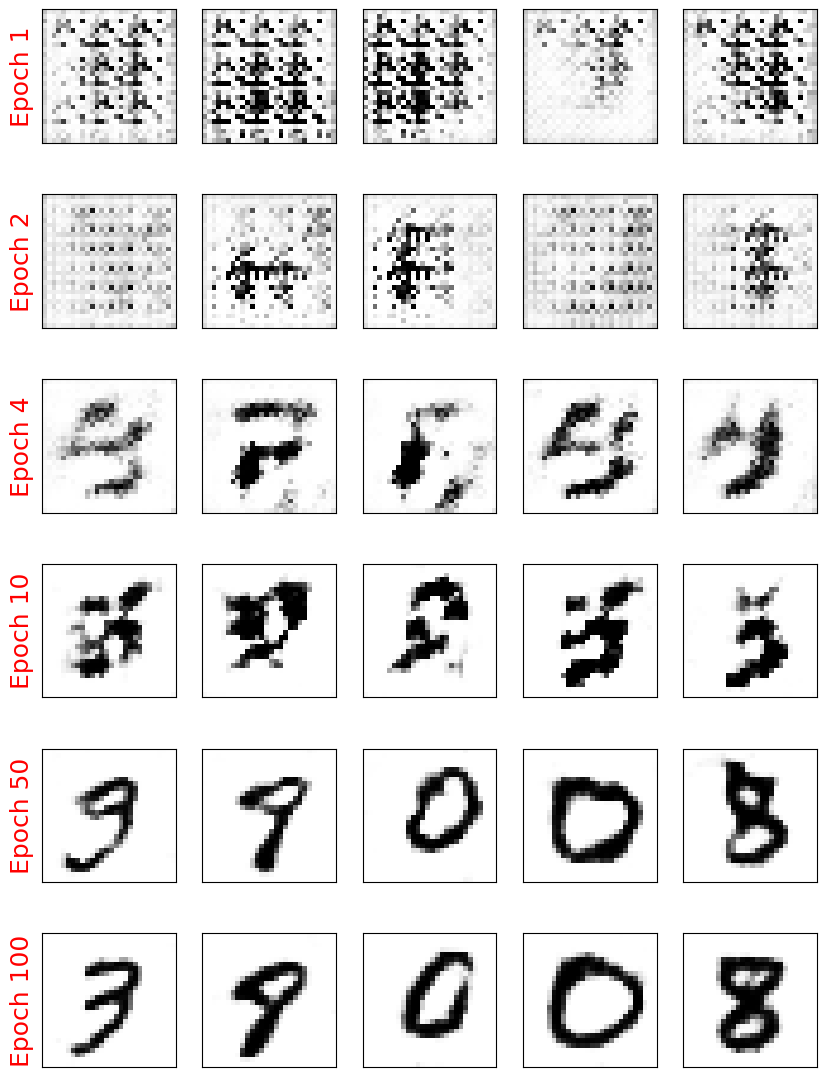

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()

## WGAN


In [9]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

device

def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0,
                           bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [10]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [11]:
from torch.autograd import grad as torch_grad


def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    # Calculate interpolation
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data

    # Calculate probability of interpolated examples
    proba_interpolated = disc_model(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1)**2).mean()
## Train the discriminator
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # Calculate probabilities on real and generated data
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()

    return d_loss.data.item()
## Train the generator
def g_train_wgan(x):
    gen_model.zero_grad()

    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)

    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()

    return g_loss.data.item()

In [12]:
import torchvision
from torchvision import transforms


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

batch_size = 512

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size,
                      shuffle=True, drop_last=True)

In [18]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [22]:
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images+1)/2.0

In [24]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

In [25]:
from tqdm import tqdm
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 100
torch.manual_seed(1)
critic_iterations = 5
mode_z = "uniform"

for epoch in range(1, num_epochs+1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(tqdm(mnist_dl, desc=f"Epoch {epoch}/{num_epochs} iterations")):
        d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))

    print(f'Epoch {epoch:03d} | D Loss >>'
          f' {torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 1/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.21it/s]


Epoch 001 | D Loss >> -0.1206


Epoch 2/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.20it/s]


Epoch 002 | D Loss >> -0.1466


Epoch 3/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.22it/s]


Epoch 003 | D Loss >> -0.1271


Epoch 4/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


Epoch 004 | D Loss >> -0.1956


Epoch 5/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.33it/s]


Epoch 005 | D Loss >> -0.2303


Epoch 6/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.20it/s]


Epoch 006 | D Loss >> -0.2630


Epoch 7/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.23it/s]


Epoch 007 | D Loss >> -0.2901


Epoch 8/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


Epoch 008 | D Loss >> -0.3022


Epoch 9/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 009 | D Loss >> -0.3157


Epoch 10/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.35it/s]


Epoch 010 | D Loss >> -0.2968


Epoch 11/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.22it/s]


Epoch 011 | D Loss >> -0.3075


Epoch 12/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 012 | D Loss >> -0.2809


Epoch 13/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 013 | D Loss >> -0.3305


Epoch 14/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.26it/s]


Epoch 014 | D Loss >> -0.3660


Epoch 15/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


Epoch 015 | D Loss >> -0.3502


Epoch 16/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.30it/s]


Epoch 016 | D Loss >> -0.3846


Epoch 17/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.23it/s]


Epoch 017 | D Loss >> -0.3996


Epoch 18/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 018 | D Loss >> -0.3895


Epoch 19/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 019 | D Loss >> -0.4095


Epoch 20/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.34it/s]


Epoch 020 | D Loss >> -0.3928


Epoch 21/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.33it/s]


Epoch 021 | D Loss >> -0.3699


Epoch 22/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


Epoch 022 | D Loss >> -0.3503


Epoch 23/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.21it/s]


Epoch 023 | D Loss >> -0.3672


Epoch 24/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 024 | D Loss >> -0.3571


Epoch 25/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.33it/s]


Epoch 025 | D Loss >> -0.3661


Epoch 26/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.33it/s]


Epoch 026 | D Loss >> -0.3361


Epoch 27/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.22it/s]


Epoch 027 | D Loss >> -0.3486


Epoch 28/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.20it/s]


Epoch 028 | D Loss >> -0.3453


Epoch 29/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.33it/s]


Epoch 029 | D Loss >> -0.3511


Epoch 30/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 030 | D Loss >> -0.3387


Epoch 31/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


Epoch 031 | D Loss >> -0.3547


Epoch 32/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.26it/s]


Epoch 032 | D Loss >> -0.3430


Epoch 33/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.26it/s]


Epoch 033 | D Loss >> -0.3408


Epoch 34/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.24it/s]


Epoch 034 | D Loss >> -0.3383


Epoch 35/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.25it/s]


Epoch 035 | D Loss >> -0.3426


Epoch 36/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 036 | D Loss >> -0.3333


Epoch 37/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.26it/s]


Epoch 037 | D Loss >> -0.3396


Epoch 38/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.22it/s]


Epoch 038 | D Loss >> -0.3453


Epoch 39/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 039 | D Loss >> -0.3421


Epoch 40/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.18it/s]


Epoch 040 | D Loss >> -0.3386


Epoch 41/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 041 | D Loss >> -0.3413


Epoch 42/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.32it/s]


Epoch 042 | D Loss >> -0.3464


Epoch 43/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.34it/s]


Epoch 043 | D Loss >> -0.3307


Epoch 44/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


Epoch 044 | D Loss >> -0.3467


Epoch 45/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.19it/s]


Epoch 045 | D Loss >> -0.3333


Epoch 46/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


Epoch 046 | D Loss >> -0.3395


Epoch 47/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 047 | D Loss >> -0.3440


Epoch 48/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 048 | D Loss >> -0.3383


Epoch 49/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.14it/s]


Epoch 049 | D Loss >> -0.3255


Epoch 50/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 050 | D Loss >> -0.3480


Epoch 51/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.19it/s]


Epoch 051 | D Loss >> -0.3403


Epoch 52/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.30it/s]


Epoch 052 | D Loss >> -0.3398


Epoch 53/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 053 | D Loss >> -0.3394


Epoch 54/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.23it/s]


Epoch 054 | D Loss >> -0.3454


Epoch 55/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 055 | D Loss >> -0.3428


Epoch 56/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.18it/s]


Epoch 056 | D Loss >> -0.3403


Epoch 57/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.25it/s]


Epoch 057 | D Loss >> -0.3371


Epoch 58/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.23it/s]


Epoch 058 | D Loss >> -0.3414


Epoch 59/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


Epoch 059 | D Loss >> -0.3395


Epoch 60/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.25it/s]


Epoch 060 | D Loss >> -0.3448


Epoch 61/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 061 | D Loss >> -0.3350


Epoch 62/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.20it/s]


Epoch 062 | D Loss >> -0.3368


Epoch 63/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 063 | D Loss >> -0.3313


Epoch 64/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 064 | D Loss >> -0.3346


Epoch 65/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 065 | D Loss >> -0.3460


Epoch 66/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.25it/s]


Epoch 066 | D Loss >> -0.3381


Epoch 67/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.24it/s]


Epoch 067 | D Loss >> -0.3335


Epoch 68/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.24it/s]


Epoch 068 | D Loss >> -0.3363


Epoch 69/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 069 | D Loss >> -0.3246


Epoch 70/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.26it/s]


Epoch 070 | D Loss >> -0.3270


Epoch 71/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 071 | D Loss >> -0.3293


Epoch 72/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.30it/s]


Epoch 072 | D Loss >> -0.3352


Epoch 73/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.18it/s]


Epoch 073 | D Loss >> -0.3255


Epoch 74/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.26it/s]


Epoch 074 | D Loss >> -0.3282


Epoch 75/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 075 | D Loss >> -0.3291


Epoch 76/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.23it/s]


Epoch 076 | D Loss >> -0.3334


Epoch 77/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.22it/s]


Epoch 077 | D Loss >> -0.3327


Epoch 78/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 078 | D Loss >> -0.3195


Epoch 79/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.18it/s]


Epoch 079 | D Loss >> -0.3208


Epoch 80/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 080 | D Loss >> -0.3219


Epoch 81/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 081 | D Loss >> -0.3236


Epoch 82/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.34it/s]


Epoch 082 | D Loss >> -0.3238


Epoch 83/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.30it/s]


Epoch 083 | D Loss >> -0.3182


Epoch 84/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.24it/s]


Epoch 084 | D Loss >> -0.3191


Epoch 85/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 085 | D Loss >> -0.3149


Epoch 86/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 086 | D Loss >> -0.3243


Epoch 87/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 087 | D Loss >> -0.3145


Epoch 88/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 088 | D Loss >> -0.3187


Epoch 89/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 089 | D Loss >> -0.3160


Epoch 90/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.21it/s]


Epoch 090 | D Loss >> -0.3187


Epoch 91/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


Epoch 091 | D Loss >> -0.3123


Epoch 92/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 092 | D Loss >> -0.3081


Epoch 93/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 093 | D Loss >> -0.3176


Epoch 94/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.17it/s]


Epoch 094 | D Loss >> -0.3131


Epoch 95/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]


Epoch 095 | D Loss >> -0.3156


Epoch 96/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.21it/s]


Epoch 096 | D Loss >> -0.3144


Epoch 97/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.27it/s]


Epoch 097 | D Loss >> -0.3160


Epoch 98/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.28it/s]


Epoch 098 | D Loss >> -0.2990


Epoch 99/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.31it/s]


Epoch 099 | D Loss >> -0.3074


Epoch 100/100 iterations: 100%|██████████| 117/117 [00:14<00:00,  8.29it/s]

Epoch 100 | D Loss >> -0.3005


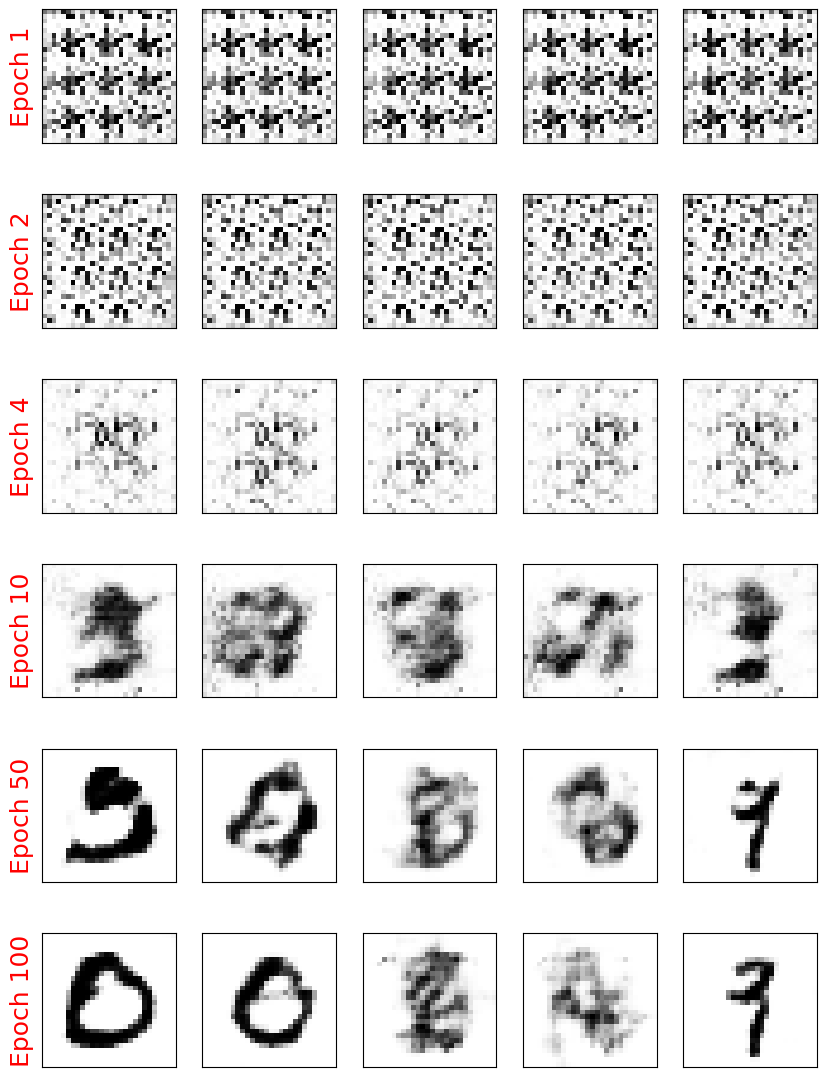

In [26]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center',
                transform=ax.transAxes)

        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')

# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()